## Add path and import libraries

In [1]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.io.votable import parse_single_table

import os
import re
import glob
from tqdm.notebook import tqdm
from collections import Counter

import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

from utils.plot_gif import create_gif

## Load and visualize data

In [4]:
test_dir = '../../../data/Gaia DR3/splits/bin_clf/bin_cat_test.parquet'
data = pd.read_parquet(test_dir)
data

,source_id,spectraltype_esphs,Cat,flux
0,4462172954111816064,B,M,"[2.0247633e-13, 2.1673632e-13, 2.1233941e-13, ..."
1,2266868075084428160,G,LM,"[1.9716584e-17, 1.8222306e-17, 1.9483047e-17, ..."
2,2264829546167239296,G,LM,"[1.9327464e-17, 1.4786532e-17, 1.31060126e-17,..."
3,2263182202872008448,F,LM,"[1.9780736e-17, 1.7344608e-17, 2.0349328e-17, ..."
4,5935439817197156608,B,M,"[1.3696473e-15, 1.3230591e-15, 1.2163171e-15, ..."
...,...,...,...,...
4723,4253397510135082624,B,M,"[3.146842e-15, 3.0153312e-15, 2.9600513e-15, 2..."
4724,5912245344513225728,M,LM,"[7.567204e-18, 7.971925e-18, 8.4509925e-18, 7...."
4725,511397259113208960,B,M,"[1.9695369e-15, 1.9344867e-15, 1.7952173e-15, ..."
4726,2263460688550959360,K,LM,"[1.0256021e-17, 1.2591463e-17, 1.9402024e-17, ..."


In [6]:
df = data.drop(columns = ['spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,4462172954111816064,M,"[2.0247633e-13, 2.1673632e-13, 2.1233941e-13, ..."
1,2266868075084428160,LM,"[1.9716584e-17, 1.8222306e-17, 1.9483047e-17, ..."
2,2264829546167239296,LM,"[1.9327464e-17, 1.4786532e-17, 1.31060126e-17,..."
3,2263182202872008448,LM,"[1.9780736e-17, 1.7344608e-17, 2.0349328e-17, ..."
4,5935439817197156608,M,"[1.3696473e-15, 1.3230591e-15, 1.2163171e-15, ..."


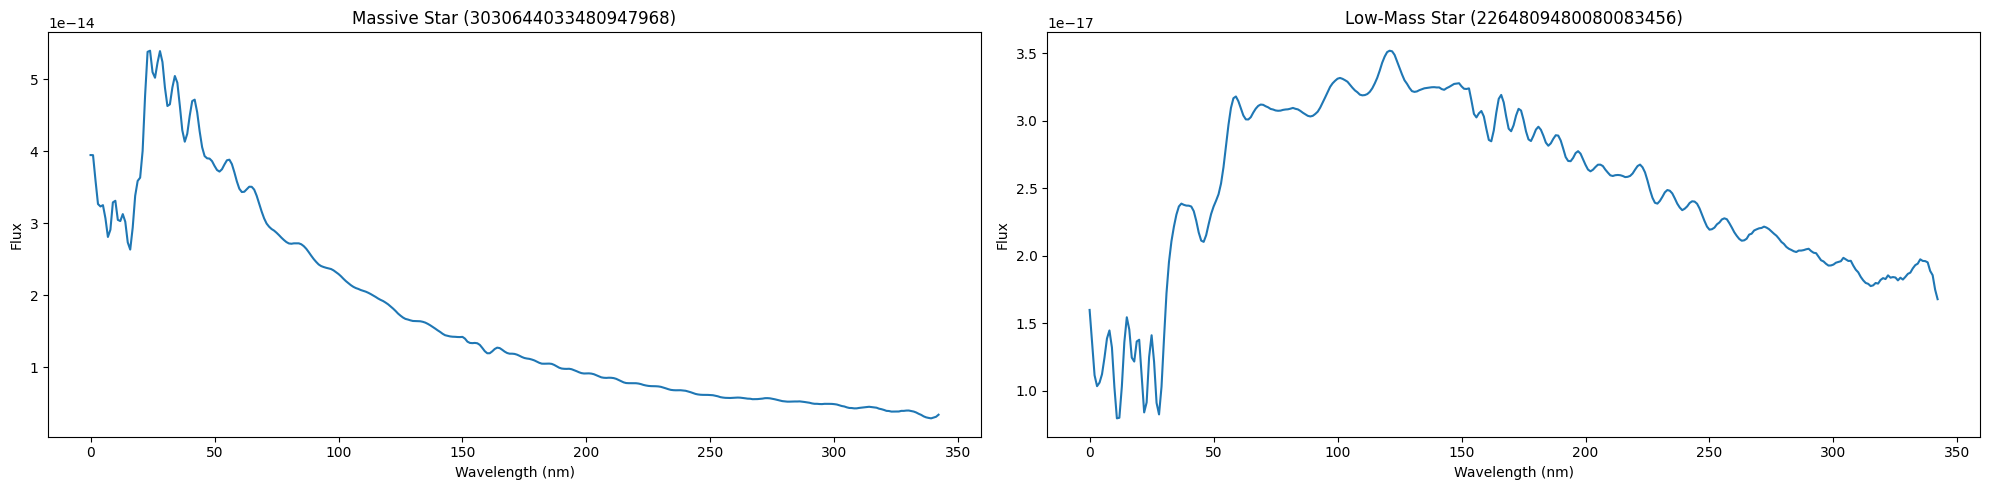

In [7]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(20, 5))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')

plt.tight_layout()
plt.show()


In [8]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 4728
Number of bins in each spectra: 343
In the dataset, we have 2346 spectra for low mass stars and 2382 spectra for high mass stars.


In [9]:
X = df['flux'].to_numpy()
y = df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X])).float()

Text(0, 0.5, 'Flux')

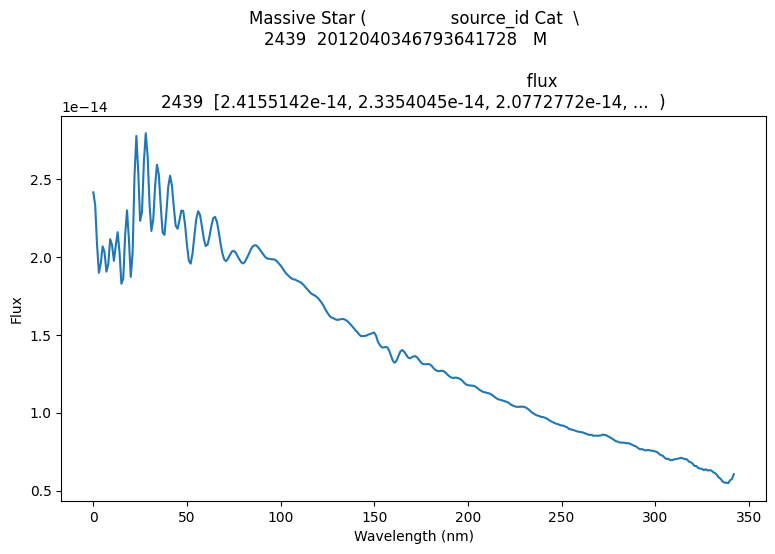

In [11]:
# Random sample from 'M' category (massive star)
sample_ms = df[df['source_id'] == 2012040346793641728].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df[df['source_id'] == 2012040346793641728]

plt.figure(figsize=(20, 5))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')

## Add low mass samples (optional)

In [45]:
test_dir = '../../../data/Gaia DR3/combined/LM_stars.parquet'
df_lm = pd.read_parquet(test_dir)
df_lm

,source_id,flux,Cat
0,2263623450631337088,"[2.4380569e-15, 2.2388932e-15, 2.0208773e-15, ...",LM
1,2263623484991072128,"[9.080353e-17, 7.900905e-17, 7.354385e-17, 7.6...",LM
2,2263625031179532800,"[4.1279026e-17, 3.6907568e-17, 3.8073304e-17, ...",LM
3,2263625649654599424,"[3.0394444e-17, 2.6702259e-17, 2.3652267e-17, ...",LM
4,2263626199410391424,"[5.687641e-18, 8.438833e-18, 6.6333053e-18, 4....",LM
...,...,...,...
9995,5937230333203165184,"[1.0422611e-17, 5.7810714e-18, 7.973631e-18, 1...",LM
9996,5937230475017452800,"[8.530493e-18, 4.4032483e-18, 5.1326193e-18, 6...",LM
9997,5937230509377200896,"[-1.3219708e-18, -2.2574377e-19, 2.4484513e-18...",LM
9998,5937230612456421888,"[2.8983347e-17, 2.3871746e-17, 2.0493077e-17, ...",LM


In [ ]:
final_df = pd.concat([df, df_lm]).reset_index(drop=True)
final_df

In [ ]:
final_df.info()

### rerun the next cell to see random examples of different spectra

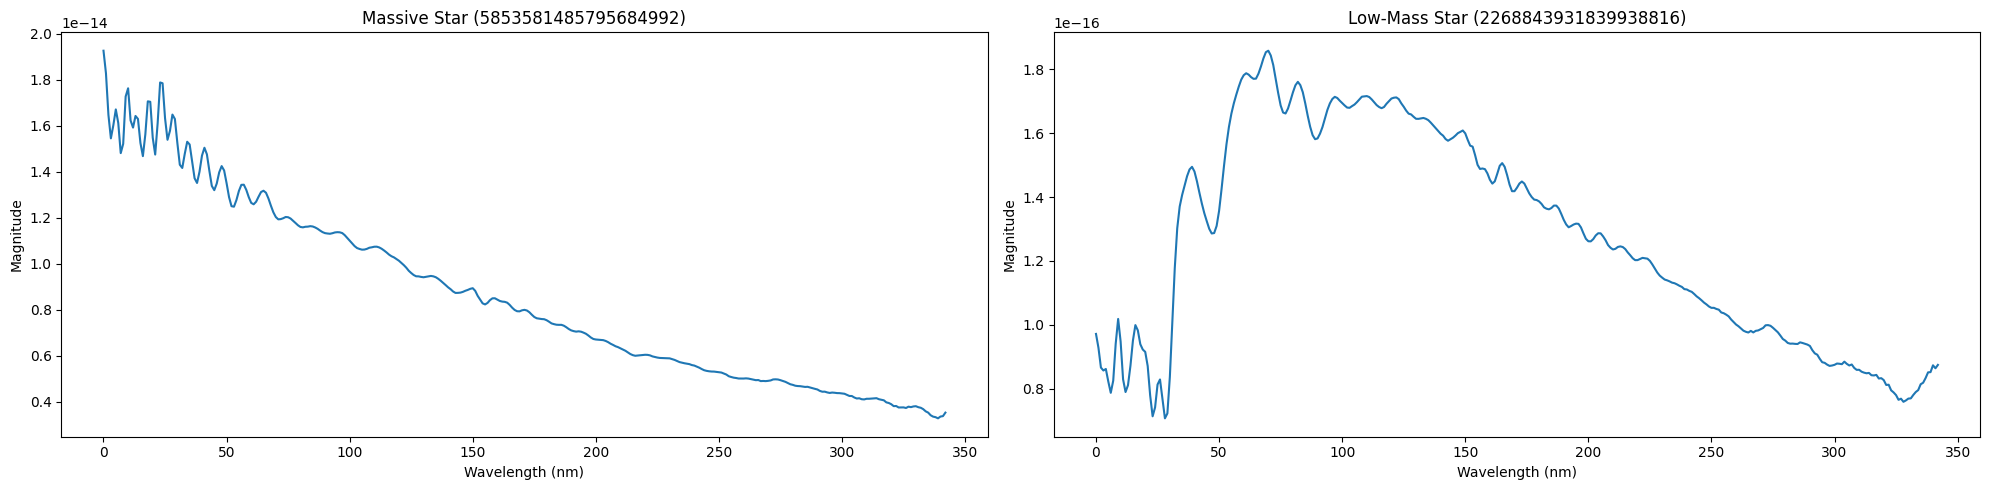

In [ ]:

# Random sample from 'M' category (massive star)
sample_ms = final_df[final_df['Cat'] == 'M'].sample(n=1).index
flux_ms = final_df['flux'].iloc[sample_ms].values[0]
object_id_ms = final_df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = final_df[final_df['Cat'] == 'LM'].sample(n=1).index
flux_lm = final_df['flux'].iloc[sample_lm].values[0]
object_id_lm = final_df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(20, 5))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [65]:
num_samples = final_df.shape[0]
spectrum_width = len(final_df['flux'][0])

num_samples_lm = final_df['Cat'].value_counts()['LM']
num_samples_m = final_df['Cat'].value_counts()['M']
num_classes = final_df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 13526
Number of bins in each spectra: 343
In the dataset, we have 12206 spectra for low mass stars and 1320 spectra for high mass stars.


In [66]:
X = final_df['flux'].to_numpy()
y = final_df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X])).float()

## Add noise to samples (optional)

In [16]:
def add_noise(spectra, noise_type='gaussian', level=0.005):
    if noise_type == 'gaussian':
        noise = np.random.normal(0, level, spectra.shape)
    elif noise_type == 'poisson':
        noise = np.random.poisson(spectra * level) / level - spectra
    elif noise_type == 'salt_pepper':
        noise = np.zeros(spectra.shape)
        salt = np.random.random(spectra.shape) < level/2
        pepper = np.random.random(spectra.shape) < level/2
        noise[salt] = 1
        noise[pepper] = -1
    return spectra + noise

def noisy_batch(X, noise_prob=1.0, **noise_params):
    mask = np.random.random(len(X)) < noise_prob
    X_noisy = X.copy()
    X_noisy[mask] = add_noise(X[mask], **noise_params)
    return X_noisy

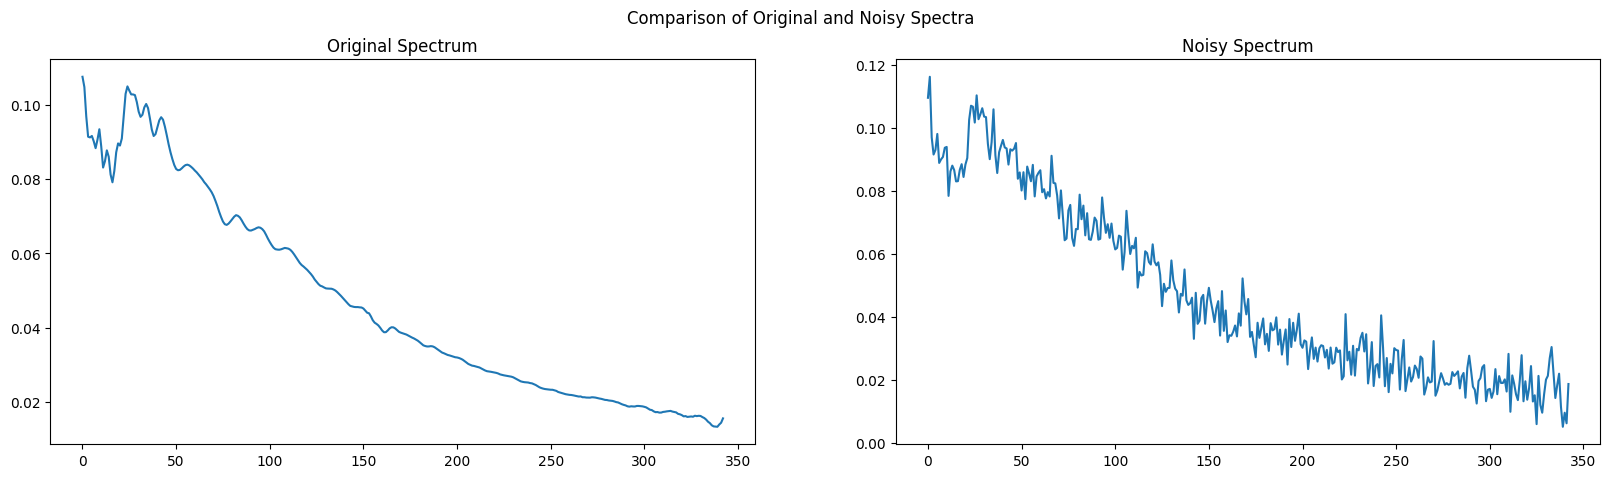

In [18]:
X_ = X
X = noisy_batch(np.array(X))

plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(X_[4])
ax1.set_title('Original Spectrum')
ax2 = plt.subplot(1, 2, 2)
ax2.plot(X[4])
ax2.set_title('Noisy Spectrum')
plt.suptitle('Comparison of Original and Noisy Spectra')

plt.show()


## Oversampling (optional)

In [21]:
smote = SMOTE(random_state=42)

X_new, y_new = smote.fit_resample(X, y)

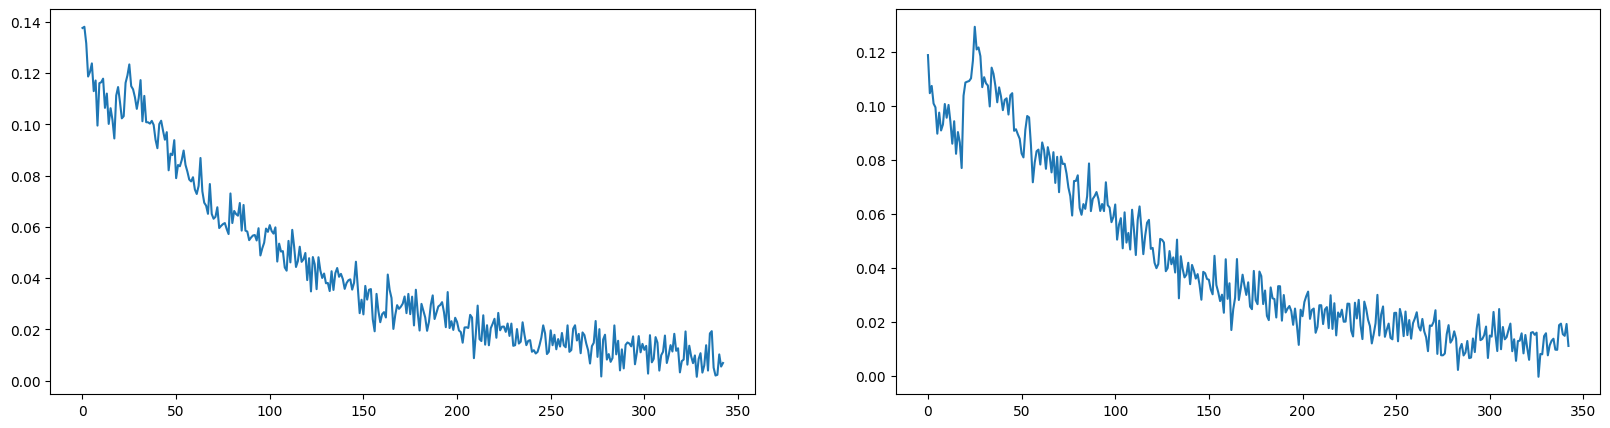

In [24]:
one_indices = np.where(y == 1.)[0]
random_index = np.random.choice(one_indices)

one_indices_new = np.where(y_new == 1.)[0]
random_index_new = np.random.choice(one_indices_new)

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(X[random_index])

plt.subplot(1,2,2)
plt.plot(X_new[random_index_new])

plt.show()

In [25]:
X, y = torch.from_numpy(X_new).float(), torch.from_numpy(y_new).float()

## Load model

In [17]:
model = torch.load('../../trained_models/cnn_gpu.pth')

C:\Users\012364\AppData\Local\Temp\ipykernel_35748\3786979639.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../../trained_models/cnn_gpu.pth')


In [14]:
model = torch.jit.load('../../trained_models/cnn_ensemble.pth')

## Predicting

In [15]:
def predict(models, X, y, verbose=True):
    # Hyperparameters
    device = 'cuda'
    
    # Move input data to the device
    X = X.to(device)
    y = y.to(device).unsqueeze(1)
    
    # Initialize metrics
    all_probs = []

    for m in models:
        # Move model to GPU
        m.to(device)
        m.eval()

        with torch.no_grad():
            output = m(X.unsqueeze(1))
            prob = torch.sigmoid(output).cpu().numpy()
            all_probs.append(prob)

    # Average probabilities across all models
    avg_probs = np.mean(all_probs, axis=0)
    preds = np.round(avg_probs).flatten()
    probs = avg_probs.flatten()

    y_np = y.cpu().numpy().flatten()
    
    # Filter out uncertain predictions
    valid_mask = ~np.isnan(preds)
    preds = preds[valid_mask]
    probs = probs[valid_mask]
    y_valid = y_np[valid_mask]
    
    # Compute metrics
    accuracy = accuracy_score(y_valid, preds)
    ra_score = roc_auc_score(y_valid, probs)
    f1 = f1_score(y_valid, preds)
    cm = confusion_matrix(y_valid, preds)
    
    # Analyze incorrect predictions
    incorrect_mask = preds != y_valid
    incorrect_probs = probs[incorrect_mask]
    incorrect_true_labels = y_valid[incorrect_mask]
    
    high_confidence_fp = sum((incorrect_probs > 0.9) & (incorrect_true_labels == 0))
    low_confidence_fn = sum((incorrect_probs < 0.1) & (incorrect_true_labels == 1))
    
    total_incorrect = len(incorrect_probs)
    total_samples = len(valid_mask)
    uncertain_samples = sum((0.1 <= probs) & (probs <= 0.9))
    
    if verbose:
        print(f"\nTotal incorrect predictions: {total_incorrect}")
        print(f"High confidence false positives (prob > 0.9): {high_confidence_fp} ({high_confidence_fp/total_incorrect:.2%})")
        print(f"Low confidence false negatives (prob < 0.1): {low_confidence_fn} ({low_confidence_fn/total_incorrect:.2%})")
        print(f"\nTotal samples: {total_samples}")
        print(f"Samples in uncertainty region (0.1 <= prob <= 0.9): {uncertain_samples} ({uncertain_samples/total_samples:.2%})")
    
    return accuracy, ra_score, f1, cm, incorrect_probs, incorrect_true_labels, valid_mask, preds

In [18]:
accuracy, auc_score, f1, cm, incorrect_probs, incorrect_true_labels, valid_mask, preds = predict(model, X, y)


Total incorrect predictions: 177
High confidence false positives (prob > 0.9): 60 (33.90%)
Low confidence false negatives (prob < 0.1): 10 (5.65%)

Total samples: 4728
Samples in uncertainty region (0.1 <= prob <= 0.9): 410 (8.67%)


Accuracy: 0.9626
AUC score: 0.9864
F1 score: 0.9636


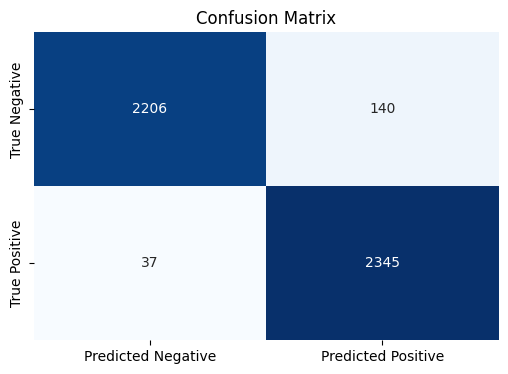

In [20]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC score: {auc_score:.4f}")
print(f"F1 score: {f1:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

## Inferencing

### On data from external studies

In [1]:
def _get_data(data_dir):
    files = glob.glob(f'{data_dir}/*.vot')
    pattern = re.compile(r'(\d+)(?=\.vot$)')

    result = pd.DataFrame(columns=['source_id', 'flux'])

    for f in files:
        match = pattern.search(os.path.basename(f))
        
        if match:
            source_id = int(match.group())
            data = parse_single_table(f).to_table().to_pandas()
            
            flux_array = data['flux'].values
            temp_df = pd.DataFrame({'source_id': [int(source_id)], 'flux': [flux_array]})
            result = pd.concat([result, temp_df], ignore_index=True)
            del temp_df

    return result

def load_data(study):
    '''
    '''
    if study == '10.1086320460':
        data_dir = '../../../data/Gaia DR3/external/10.1086320460'
        result_df = _get_data(data_dir)
    if study == '10.10510004-6361200912659':
        data_dir = '../../../data/Gaia DR3/external/10.10510004-6361200912659'        
        result_df = _get_data(data_dir)
        
    return result_df

In [11]:
df = load_data(study='10.10510004-6361200912659')
df

,source_id,flux
0,168726523211215360,"[7.971991e-15, 7.7218945e-15, 7.924876e-15, 7...."
1,182071570715713024,"[2.4658967e-13, 2.7639645e-13, 2.642298e-13, 2..."
2,2007416556811088768,"[2.5756778e-14, 2.5582856e-14, 2.2699746e-14, ..."
3,2007418961992863744,"[3.1929026e-15, 3.121047e-15, 2.9039383e-15, 2..."
4,2007423050801646720,"[2.7837475e-15, 2.831188e-15, 2.7822756e-15, 2..."
...,...,...
273,6057676201358478336,"[4.1810995e-15, 4.3053003e-15, 4.294834e-15, 4..."
274,6057680423278480512,"[1.5347256e-14, 1.4353007e-14, 9.109478e-15, 7..."
275,6057680496326765184,"[4.30729e-14, 4.4313447e-14, 3.9557885e-14, 3...."
276,6095347496917833472,"[3.6326297e-13, 3.7530428e-13, 3.6965008e-13, ..."


In [12]:
X = df['flux'].to_numpy()

# L2 normalization
X = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X])).float()

In [16]:
def inference(models, X, verbose=True):
    print("Starting inference..")
    # hyperparameters
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize lists to store final predictions and probabilities
    final_preds, final_probs = [], []

    print(f"Model: {models}")
    print(f"Using device: {device}")
    print(f"Data shape: {X.shape}")
    print(f"Data size: {(X.numel()*X.element_size())/(1024 **2):.4f} MB")

    # Move input data to the device
    X = X.to(device)
    print(f"Moved data to {device}!")

    # Initialize a list to store probabilities from all models
    all_model_probs = []

    for m in models:
        # Move model to GPU
        m.to(device)
        m.eval()
        
        with torch.no_grad():
            output = m(X.unsqueeze(1))
            prob = torch.sigmoid(output).cpu().numpy()
            all_model_probs.append(prob)

    # Average probabilities across all models
    avg_probs = np.mean(all_model_probs, axis=0)
    
    # Calculate final predictions by rounding the averaged probabilities
    final_preds = np.round(avg_probs)

    # Convert predictions and probabilities to numpy arrays
    final_probs = np.array(avg_probs)
    final_preds = np.array(final_preds)

    print("Finished inference!")
    
    return final_preds, final_probs

In [17]:
preds, _ = inference(model, X)

Starting inference..
Model: [CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2720, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
), CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2720, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
), CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=27

In [18]:
value_counts = Counter(preds.flatten().astype(int))
print(f"Value Counts: {value_counts}")

Value Counts: Counter({1: 256, 0: 22})


### On >1 million impartially selected sources

In [6]:
impartial_sources = '../../../data/Gaia DR3/combined/impartial_xp_coord.parquet'

impartial_spectra = pd.read_parquet(impartial_sources)

In [7]:
impartial_spectra

,source_id,ra,dec,flux
0,5937173300407375616,250.247043,-51.593826,"[2.1760128e-17, 2.8403983e-17, 2.5246224e-17, ..."
1,5937081353758582016,251.645316,-51.613334,"[8.443173e-19, -4.5855413e-20, 2.3197077e-18, ..."
2,5937201200518016768,250.622534,-51.278547,"[1.0169807e-17, 6.2980932e-18, 4.4465553e-18, ..."
3,5937201200518017024,250.616240,-51.279443,"[-1.9316115e-18, -4.0893435e-18, 9.551702e-19,..."
4,5937081388118319616,251.626566,-51.625500,"[-7.4537416e-19, 7.237867e-19, 3.7499377e-18, ..."
...,...,...,...,...
1204488,5616972905625943168,110.344556,-24.053983,"[9.998206e-18, 8.298211e-18, 8.1598654e-18, 8...."
1204489,5616734311599382144,112.142247,-24.760026,"[2.0003316e-18, 3.2607307e-18, 2.7548696e-18, ..."
1204490,5616734345959112576,112.171708,-24.753497,"[5.3145056e-18, 1.7505754e-18, 1.4582408e-19, ..."
1204491,5616973073121307648,110.322070,-24.064154,"[6.4910025e-18, 2.7324015e-18, 2.9787787e-18, ..."


In [8]:
X_inference = impartial_spectra['flux'].to_numpy()

# L2 normalization
X_inference = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X_inference])).float()

In [9]:
print(X_inference.shape, type(X_inference))

torch.Size([1204493, 343]) <class 'torch.Tensor'>


In [10]:
# batched inference
def inference(models, X, batch_size=1024, verbose=True):
    
    print("Starting inference..")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    final_preds, final_probs = [], []
    
    num_batches = int(np.ceil(len(X) / batch_size))

    if verbose:
        print(f"Model: {models}")
        print(f"Using device: {device}")
        print(f"Data shape: {X.shape}")
        print(f"Data size: {(X.numel()*X.element_size())/(1024 **2):.4f} MB")
        print(f"Number of batches: {num_batches}")

    # Move input data to the device
    X = X.to(device)
    print(f"Moved data to {device}!")

    for i in tqdm(range(num_batches), desc="Processing Batches", dynamic_ncols=True):
        
        X_batch = X[i * batch_size: (i + 1) * batch_size]
        batch_probs = []
        
        for m in models:
            
            # move model to gpu
            m.to(device)
            m.eval()
            
            with torch.no_grad():

                output = m(X_batch.unsqueeze(1))
                prob = torch.sigmoid(output).cpu().numpy()
                batch_probs.append(prob)

        avg_probs_batch = np.mean(batch_probs, axis=0)
        
        avg_preds_batch = np.round(avg_probs_batch)

        final_probs.extend(avg_probs_batch)
        final_preds.extend(avg_preds_batch)
            
    final_preds = np.array(final_preds)
    final_probs = np.array(final_probs)
    
    print("Finished inference!")

    return final_preds, final_probs

In [16]:
preds, probs = inference(model, X_inference, batch_size=256)

Starting inference..
Model: [CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2720, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
), CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2720, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
), CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=27

Processing Batches:   0%|          | 0/4706 [00:00<?, ?it/s]

Finished inference!


In [17]:
value_counts = Counter(preds.flatten().astype(int))
print(f"Value Counts: {value_counts}")

Value Counts: Counter({0: 1193196, 1: 11297})


## Combine and save results

In [28]:
preds_df = pd.DataFrame({
    'prediction': np.squeeze(preds),
    'probability': np.squeeze(probs)
})
result_df = pd.concat([impartial_spectra, preds_df], axis=1)
result_df.head()

,source_id,ra,dec,flux,prediction,probability
0,5937173300407375616,250.247043,-51.593826,"[2.1760128e-17, 2.8403983e-17, 2.5246224e-17, ...",0.0,0.018551
1,5937081353758582016,251.645316,-51.613334,"[8.443173e-19, -4.5855413e-20, 2.3197077e-18, ...",0.0,0.000053
2,5937201200518016768,250.622534,-51.278547,"[1.0169807e-17, 6.2980932e-18, 4.4465553e-18, ...",0.0,0.000522
3,5937201200518017024,250.616240,-51.279443,"[-1.9316115e-18, -4.0893435e-18, 9.551702e-19,...",0.0,0.000456
4,5937081388118319616,251.626566,-51.625500,"[-7.4537416e-19, 7.237867e-19, 3.7499377e-18, ...",0.0,0.000051


In [40]:
massive_df = result_df[(result_df['prediction'] == 1) & (result_df['probability'] > 0.89)]
low_mass_df = result_df[(result_df['prediction'] == 0) & (result_df['probability'] < 0.11)]

In [47]:
num_rows_filtered = len(massive_df)
if len(low_mass_df) > 0:
    sampled_zero_class_df = low_mass_df.sample(n=num_rows_filtered * 100, replace=True, random_state=42)
else:
    sampled_zero_class_df = pd.DataFrame(columns=result_df.columns)

high_confidence_result_df = pd.concat([massive_df, sampled_zero_class_df], ignore_index=True)

In [48]:
high_confidence_result_df.to_parquet('../../../results/high_confidence_impartial_xp_pred_cnn.parquet')

## Plot gif with results

In [5]:
results_df = pd.read_parquet('../../../results/impartial_xp_pred_cnn.parquet')

In [7]:
create_gif(coords=list(zip(results_df['ra'][:100], results_df['dec'][:100])), predictions=results_df['prediction'][:100], coord_type='ra_dec', output_file='plot.gif')